# What's NMS and Soft-NMS? and how they work?

In [1]:
import VisionToolKit as vtk
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [2]:
def readImg(pth):
    hourse = cv2.imread(pth)
    hourse = cv2.cvtColor(hourse, cv2.COLOR_BGR2RGB)
    return hourse

#### let's see a hourse image and annotation.

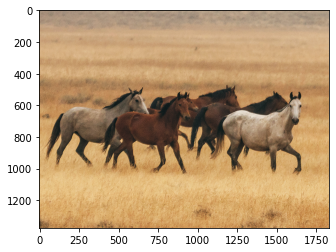

In [3]:
hourse1 = readImg('./hourse/hourse1.jpg')
vtk.imshow(hourse1)

In [14]:
bbox1 = np.array([
                [84.17647058823525, 476.7647058823529, 701.8235294117646, 1016.4705882352941],        # 0.8
                [390.0588235294117, 489.99999999999994, 968.0, 1047.3529411764705],                   # 0.9
                [685.6470588235294, 476.7647058823529, 1288.5882352941176, 903.235294117647],         # 0.6
                [945.9411764705881, 519.4117647058823, 1588.5882352941176, 959.1176470588234],        # 0.65
                [1069.470588235294, 495.8823529411764, 1675.3529411764705, 1044.4117647058822],       # 0.9
                [54.76470588235293, 441.4705882352941, 692.9999999999999, 1004.7058823529411],        # 0.81
                [1131.235294117647, 501.7647058823529, 1707.705882352941, 1051.764705882353]          # 0.89
                ])

score1 = np.array([0.8, 0.9, 0.6, 0.65, 0.9, 0.81, 0.89])
# concat them for later use
dets = np.hstack((np.asarray(bbox1), np.asarray(score1).reshape(-1, 1)))

#### show bbox

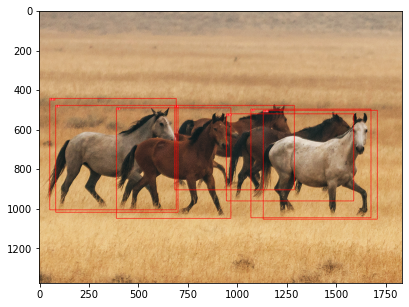

In [5]:
drawed1 = vtk.draw_bbox(hourse1, bbox1, score1.tolist())
plt.figure(figsize=(16, 5))
plt.imshow(drawed1)

In [6]:
vtk.imsave('ori.jpg', drawed1)

### NMS

In [16]:
# https://github.com/rbgirshick/fast-rcnn/blob/master/lib/utils/nms.py
def nms(dets, iou_thresh):
    x1 = dets[:, 0]
    y1 = dets[:, 1]
    x2 = dets[:, 2]
    y2 = dets[:, 3]

    scores = dets[:, -1]

    areas = (x2 - x1 + 1) * (y2 - y1 + 1)

    order = scores.argsort()[::-1]  # array([4, 1, 0, 3, 2], dtype=int64)
    #print(order)
    keep = []
    while order.size > 0:
        i = order[0] # 4
        keep.append(i)

        xx1 = np.maximum(x1[i], x1[order[1:]])  # x1[4], x1[1,0,3,2]=>[1069.47058824, 1069.47058824, 1069.47058824, 1069.47058824]
        yy1 = np.maximum(y1[i], y1[order[1:]])  # y1[4], y1[1,0,3,2]=>[495.88235294, 495.88235294, 519.41176471, 495.88235294]
        xx2 = np.minimum(x2[i], x2[order[1:]])  # x2[4], x2[1,0,3,2]=>[ 968.        ,  701.82352941, 1588.58823529, 1288.58823529]
        yy2 = np.minimum(y2[i], y2[order[1:]])  # y2[4], y2[1,0,3,2]=>[1044.41176471, 1016.47058824,  959.11764706,  903.23529412]

        w = np.maximum(0.0, xx2 - xx1 + 1)
        h = np.maximum(0.0, yy2 - yy1 + 1)

        inter = w * h
        ovr = inter / (areas[i] + areas[order[1:]] - inter)

        inds = np.where(ovr <= iou_thresh)[0]
        order = order[inds + 1]
        #print(order)
        
    return keep

In [17]:
keep = nms(dets, iou_thresh=0.5);keep

[4, 1, 5, 2]

#### let's see the result

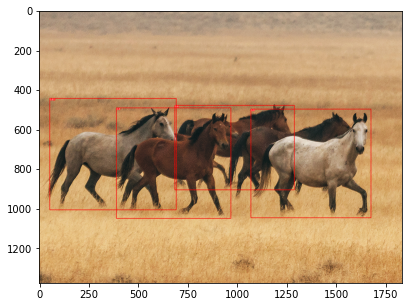

In [18]:
drawed1 = vtk.draw_bbox(hourse1, bbox1[keep], score1[keep].tolist())
plt.figure(figsize=(16, 5))
plt.imshow(drawed1)

In [11]:
vtk.imsave('nms.jpg', drawed1)

#### you can see that nms works fine, however the second house from the right side was omited.

==========================================================================================================

### Soft-NMS

In [68]:
# https://github.com/DocF/Soft-NMS/blob/master/soft_nms.py
def py_cpu_softnms(dets, sc, Nt=0.5, sigma=0.5, thresh=0.25, method=2):
    """
    py_cpu_softnms
    :param dets:   boexs 坐标矩阵 format [y1, x1, y2, x2]
    :param sc:     每个 boxes 对应的分数
    :param Nt:     iou 交叠门限
    :param sigma:  使用 gaussian 函数的方差
    :param thresh: 最后的分数门限
    :param method: 使用的方法
    :return:       留下的 boxes 的 index
    """

    # indexes concatenate boxes with the last column
    N = dets.shape[0]
    indexes = np.array([np.arange(N)])
    dets = np.concatenate((dets, indexes.T), axis=1)

    # the order of boxes coordinate is [y1,x1,y2,x2]
    y1 = dets[:, 0]
    x1 = dets[:, 1]
    y2 = dets[:, 2]
    x2 = dets[:, 3]
    scores = sc
    areas = (x2 - x1 + 1) * (y2 - y1 + 1)

    for i in range(N):
        # intermediate parameters for later parameters exchange
        tBD = dets[i, :].copy()
        tscore = scores[i].copy()
        tarea = areas[i].copy()
        pos = i + 1

        #
        if i != N-1:
            maxscore = np.max(scores[pos:], axis=0)
            maxpos = np.argmax(scores[pos:], axis=0)
        else:
            maxscore = scores[-1]
            maxpos = 0
        if tscore < maxscore:
            dets[i, :] = dets[maxpos + i + 1, :]
            dets[maxpos + i + 1, :] = tBD
            tBD = dets[i, :]

            scores[i] = scores[maxpos + i + 1]
            scores[maxpos + i + 1] = tscore
            tscore = scores[i]

            areas[i] = areas[maxpos + i + 1]
            areas[maxpos + i + 1] = tarea
            tarea = areas[i]

        # IoU calculate
        xx1 = np.maximum(dets[i, 1], dets[pos:, 1])
        yy1 = np.maximum(dets[i, 0], dets[pos:, 0])
        xx2 = np.minimum(dets[i, 3], dets[pos:, 3])
        yy2 = np.minimum(dets[i, 2], dets[pos:, 2])

        w = np.maximum(0.0, xx2 - xx1 + 1)
        h = np.maximum(0.0, yy2 - yy1 + 1)
        inter = w * h
        ovr = inter / (areas[i] + areas[pos:] - inter)

        # Three methods: 1.linear 2.gaussian 3.original NMS
        if method == 1:  # linear
            weight = np.ones(ovr.shape)
            weight[ovr > Nt] = weight[ovr > Nt] - ovr[ovr > Nt]
        elif method == 2:  # gaussian
            weight = np.exp(-(ovr * ovr) / sigma)
        else:  # original NMS
            weight = np.ones(ovr.shape)
            weight[ovr > Nt] = 0

        scores[pos:] = weight * scores[pos:]

    # select the boxes and keep the corresponding indexes
    inds = dets[:, 4][scores > thresh]
    keep = inds.astype(int)

    return keep

In [82]:
bbox1 = np.array([
                [84.17647058823525, 476.7647058823529, 701.8235294117646, 1016.4705882352941],        # 0.8
                [390.0588235294117, 489.99999999999994, 968.0, 1047.3529411764705],                   # 0.9
                [685.6470588235294, 476.7647058823529, 1288.5882352941176, 903.235294117647],         # 0.6
                [945.9411764705881, 519.4117647058823, 1588.5882352941176, 959.1176470588234],        # 0.65
                [1069.470588235294, 495.8823529411764, 1675.3529411764705, 1044.4117647058822],       # 0.9
                [54.76470588235293, 441.4705882352941, 692.9999999999999, 1004.7058823529411],        # 0.81
                [1131.235294117647, 501.7647058823529, 1707.705882352941, 1051.764705882353]          # 0.89
                ])

score1 = np.array([0.8, 0.9, 0.6, 0.65, 0.9, 0.81, 0.89])

In [83]:
keep = py_cpu_softnms(bbox1[:,[1, 0, 3, 2]], score1);keep

array([1, 4, 5, 2, 3])

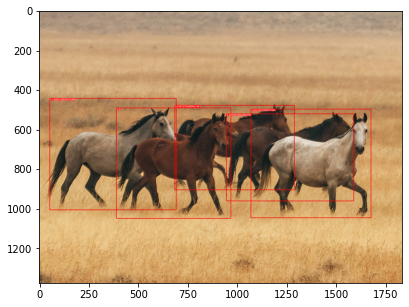

In [84]:
drawed1 = vtk.draw_bbox(hourse1, bbox1[keep], score1[keep].tolist())
plt.figure(figsize=(16, 5))
plt.imshow(drawed1)

In [74]:
vtk.imsave('softnms_ori.jpg', drawed1)

In [75]:
#### 2020/5/28